# BERT Dataset Exploration: BBAW Egyptian Corpus

This notebook explores the `bbaw_egyptian` dataset (provided as a parquet file) to assess its suitability for training a BERT-like model for Ancient Egyptian hieroglyphs.

## Goals
1. Load the parquet file.
2. Filter for records containing hieroglyphs.
3. Analyze the distribution of text lengths and vocabulary.
4. Preview the data for tokenization.

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Path to the downloaded parquet file
parquet_path = Path('../data/raw/bbaw_huggingface.parquet')

print(f"Loading {parquet_path}...")
df = pd.read_parquet(parquet_path)

print(f"Total records: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Loading ../../huggingface/train-00000-of-00001.parquet...
Total records: 100736
Columns: ['transcription', 'translation', 'hieroglyphs']


,transcription,translation,hieroglyphs
0,"⸢pḏ,wt-9⸣ n =f [⸮ḥtr?] ⸢m⸣",... die Neun-Bogenvölker ... zu ihm ... Pferde...,
1,"ḥtr tp,j ꜥꜣ n ḥm =f Ꜥꜣ-nḫt,w",[Pferde]: Das erste große Pfergespann seiner M...,
2,"⸢wr⸣.pl ⸢ꜥꜣi̯⸣.pl n.w ⸢Rṯn,w⸣ ⸢jni̯⸣ ⸢ḥm⸣ ⸢=f⸣...",[Gefangene]: Die großen Oberhäupter von Retjen...,
3,"ḏd-mdw jn ꜣs,t wr,t mw,t-nṯr","Worte sprechen durch Isis, die Große, die Gott...",
4,"sꜣ =j mri̯ =j Rꜥw-msi̯-sw-mri̯-Jmn ⸢ꜥḥꜥ,w⸣ =k ...","""Mein geliebter Sohn Ramses-meriamun, deine Le...",


## 1. Filter for Hieroglyphs

We are primarily interested in records that have explicit hieroglyphic encodings (Gardiner codes).

In [4]:
# Filter for non-empty hieroglyphs
df_hieroglyphs = df[df['hieroglyphs'].notna() & (df['hieroglyphs'] != '')].copy()

print(f"Records with hieroglyphs: {len(df_hieroglyphs)}")
print(f"Percentage: {len(df_hieroglyphs) / len(df) * 100:.2f}%")

print("\nSample records:")
for i in range(5):
    row = df_hieroglyphs.iloc[i]
    print(f"\n--- Record {i} ---")
    print(f"Transcription: {row['transcription']}")
    print(f"Translation: {row['translation']}")
    print(f"Hieroglyphs: {row['hieroglyphs']}")

Records with hieroglyphs: 35503
Percentage: 35.24%

Sample records:

--- Record 0 ---
Transcription: jr,j-pꜥ,t ḥꜣ,tj-ꜥ ḫtm,w-bj,tj smr-wꜥ,tj jm,j-rʾ-ḥm(,pl)-nṯr-n-Stj,t-nb,t-Ꜣb,w jmꜣḫ,y-ḫr-Jnp,w Zꜣ-rnp,wt.pl jri̯(.w) n Zꜣ,t-ṯnj  ḏd
Translation: Hereditary noble and prince, royal seal-bearer and sole friend (of the king), overseer of the priests of Satet, Mistress of Elephantine, one distinguished in front of Anubis, Sarenput, born of Sat-tjeny, says:
Hieroglyphs: D21 :Q3 :D36 F4 :D36 L2 -X1 :S19 S29 -U23 -T21 :X1 G17 -D21 :Z1 -R8 -U36 -S4 -F29 -X1 :X1 -B1 -V30 :X1 -U23 -D58 -G43 -N25 :O49 M17 -U1 -F39&Aa1 -M17 -M17 -Aa1 :D21 -E16 -A40 G39 -D21 :N35 :Q3 -G43 -X1 :Z3 -A1 D4\ N35 G39&X1 -V13 :N35 :Z1 -M17 -B1  I10&D46

--- Record 1 ---
Transcription: j ꜥnḫ.w[.pl] [tp,j].pl-tꜣ swꜣ.t(j) =sn ḥr jz pn m-ḫdi̯ m ḫsfi̯.t m mri̯ ṯn nṯr.pl =ṯn jw =ṯn 〈r〉 dwꜣ nṯr r pr,t-ḫrw n kꜣ n(,j)  jmꜣḫ(,w) ḥꜣ,tj-ꜥ Zꜣ-rnp,wt.pl ḏd
Translation: O living ones, who are upon the earth, who shall pass along this tom

## 2. Text Length Analysis

Analyze the length of the hieroglyphic sequences (number of signs/groups) to understand the context window requirements for BERT.

Length Statistics:
count    35503.000000
mean        25.015717
std         25.443179
min          1.000000
25%         10.000000
50%         18.000000
75%         32.000000
max        899.000000
Name: length, dtype: float64


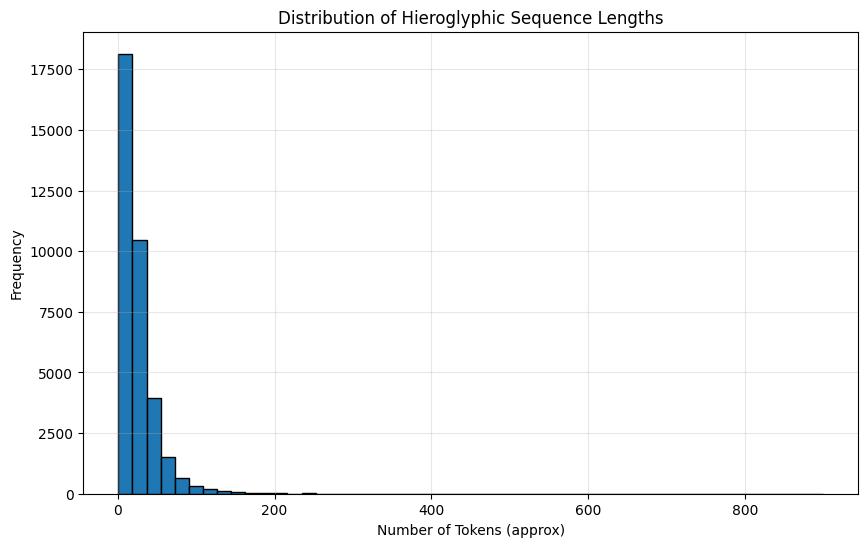

In [5]:
# Calculate length (approximate by splitting on space)
df_hieroglyphs['length'] = df_hieroglyphs['hieroglyphs'].str.split().str.len()

print("Length Statistics:")
print(df_hieroglyphs['length'].describe())

plt.figure(figsize=(10, 6))
plt.hist(df_hieroglyphs['length'], bins=50, edgecolor='black')
plt.title('Distribution of Hieroglyphic Sequence Lengths')
plt.xlabel('Number of Tokens (approx)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

## 3. Vocabulary Analysis

Identify the unique Gardiner signs used in the corpus.

In [6]:
from collections import Counter
import re

# Simple tokenizer for Gardiner codes (e.g., G43, M17)
# This regex looks for alphanumeric codes, ignoring separators like -, :, *
def extract_signs(text):
    # Basic extraction of codes like A1, G43, N35
    # This might need refinement based on the exact encoding scheme
    return re.findall(r'[A-Z][0-9]+[A-Z]*', text)

all_signs = []
for text in df_hieroglyphs['hieroglyphs']:
    all_signs.extend(extract_signs(text))

sign_counts = Counter(all_signs)

print(f"Total sign tokens: {len(all_signs):,}")
print(f"Unique signs: {len(sign_counts):,}")

print("\nTop 20 most common signs:")
for sign, count in sign_counts.most_common(20):
    print(f"{sign}: {count:,}")

Total sign tokens: 753,013
Unique signs: 1,826

Top 20 most common signs:
X1: 64,688
N35: 52,007
D21: 36,530
M17: 35,706
Z1: 34,299
G17: 24,039
Z7: 23,455
Z2: 21,209
I9: 21,059
S29: 17,979
D36: 15,646
G1: 14,367
Y1: 12,560
A1: 9,874
G7: 9,786
V28: 9,534
Q3: 9,241
G43: 9,028
D46: 8,755
N5: 8,415
